https://www.kaggle.com/c/state-farm-distracted-driver-detection  

based on prev work by bmt.
Kaggle-dogs-cats-kernel/Kaggle-cats-dogs-redux-ensemble-1-load-data-model-predict.ipynb

In [1]:
sample_or_prod = False #True = sample, False = production
batch_size=32 # was 64, try small size due to out of memory error.

c0: safe driving  
c1: texting - right  
c2: talking on the phone - right  
c3: texting - left  
c4: talking on the phone - left  
c5: operating the radio  
c6: drinking  
c7: reaching behind  
c8: hair and makeup  
c9: talking to passenger  

In [2]:
cat_desc = ['safe driving', 'texting - right', 'talking on the phone - right', 
            'texting - left', 'talking on the phone - left', 'operating the radio', 
            'drinking', 'reaching behind', 'hair and makeup', 'talking to passenger']
print ("cat_desc:", type(cat_desc), len(cat_desc))

('cat_desc:', <type 'list'>, 10)


In [3]:
HOMEPATH = "/home/ubuntu/fastai/"
DATA_PATH = HOMEPATH + "data/state/"
print("HOMEPATH:", HOMEPATH)
print("DATA_PATH:", DATA_PATH)
import os
from __future__ import division, print_function


('HOMEPATH:', '/home/ubuntu/fastai/')
('DATA_PATH:', '/home/ubuntu/fastai/data/state/')


In [4]:
import os
from datetime import datetime
from glob import glob
from random import shuffle
from shutil import copyfile
import pandas as pd
import numpy as np
import random
import cv2
import gc

In [5]:
MODEL_PATH = DATA_PATH+"models/"
RESULTS_PATH = DATA_PATH+"results/"


SAMPLE_DATA_PATH = DATA_PATH + "sample/"#choose this for testing or above for production
SAMPLE_TEST_PATH = SAMPLE_DATA_PATH+"test/"
SAMPLE_TRAIN_PATH = SAMPLE_DATA_PATH + "train/"
SAMPLE_VALID_PATH = SAMPLE_DATA_PATH + "valid/"


TEST_PATH = DATA_PATH+"test/"
TRAIN_PATH = DATA_PATH + "train/"
VALID_PATH = DATA_PATH + "valid/"


if sample_or_prod:
    WORKING_DATA  = SAMPLE_DATA_PATH
    WORKING_TEST  = SAMPLE_TEST_PATH
    WORKING_TRAIN = SAMPLE_TRAIN_PATH
    WORKING_VALID = SAMPLE_VALID_PATH
    s_or_p = "_sample_"
else:
    WORKING_DATA  = DATA_PATH
    WORKING_TEST  = TEST_PATH
    WORKING_TRAIN = TRAIN_PATH
    WORKING_VALID = VALID_PATH
    s_or_p = "_prod_"

    
print ("WORKING_DATA:", WORKING_DATA)
print ("WORKING_TEST:", WORKING_TEST)
print ("WORKING_TRAIN:", WORKING_TRAIN)
print ("WORKING_VALID:", WORKING_VALID)
print ("s_or_p:", s_or_p)

WORKING_DATA: /home/ubuntu/fastai/data/state/
WORKING_TEST: /home/ubuntu/fastai/data/state/test/
WORKING_TRAIN: /home/ubuntu/fastai/data/state/train/
WORKING_VALID: /home/ubuntu/fastai/data/state/valid/
s_or_p: _prod_


In [6]:
os.chdir(DATA_PATH)
print (os.getcwd())
!tree -d

/home/ubuntu/fastai/data/state
.
├── models
├── results
├── sample
│   ├── test
│   │   └── unknown
│   ├── train
│   │   ├── c0
│   │   ├── c1
│   │   ├── c2
│   │   ├── c3
│   │   ├── c4
│   │   ├── c5
│   │   ├── c6
│   │   ├── c7
│   │   ├── c8
│   │   └── c9
│   └── valid
│       ├── c0
│       ├── c1
│       ├── c2
│       ├── c3
│       ├── c4
│       ├── c5
│       ├── c6
│       ├── c7
│       ├── c8
│       └── c9
├── test
│   └── unknown
├── train
│   ├── c0
│   ├── c1
│   ├── c2
│   ├── c3
│   ├── c4
│   ├── c5
│   ├── c6
│   ├── c7
│   ├── c8
│   └── c9
└── valid
    ├── c0
    ├── c1
    ├── c2
    ├── c3
    ├── c4
    ├── c5
    ├── c6
    ├── c7
    ├── c8
    └── c9

51 directories


In [7]:
def dirFileList(dir_path):
    return [name for name in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, name))]


In [8]:
CATEGORIES = []


for i in range(10):
    CATEGORIES.append("c"+str(i)+"/")
print ("CATEGORIES:", CATEGORIES)

CATEGORIES: ['c0/', 'c1/', 'c2/', 'c3/', 'c4/', 'c5/', 'c6/', 'c7/', 'c8/', 'c9/']


In [9]:
UNKNOWN = 'unknown/'

DATA_DIR_LIST = [DATA_PATH, SAMPLE_DATA_PATH, SAMPLE_TEST_PATH, SAMPLE_TEST_PATH+UNKNOWN, SAMPLE_TRAIN_PATH, 
                 SAMPLE_VALID_PATH, TEST_PATH, TEST_PATH+UNKNOWN, TRAIN_PATH, VALID_PATH, MODEL_PATH, RESULTS_PATH]



for category in CATEGORIES:
    DATA_DIR_LIST.append(TRAIN_PATH+category)
    DATA_DIR_LIST.append(VALID_PATH+category)
    DATA_DIR_LIST.append(SAMPLE_TRAIN_PATH+category)
    DATA_DIR_LIST.append(SAMPLE_VALID_PATH+category)

In [10]:
def showLayersInfo(model):
    print ("Number of layers : ", len(model.layers))
    count = 0
    for layer in model.layers:
        print (count, type(layer), ", trainable:", layer.trainable)
        print ("input:", layer.input_shape, ", output:",layer.output_shape, ", len(weights)", len(layer.get_weights()), "\n")
        count +=1

In [11]:
def plot_history(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validate'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validate'], loc='upper left')
    plt.show()

In [12]:
def listDirsFileCount(DATA_DIR_LIST):
    DATA_DIR_LIST = sorted(DATA_DIR_LIST)
    for dir_ in DATA_DIR_LIST:
        print (dir_, len(dirFileList(dir_)))
        
#NB: could have used global DATA_DIR_LIST  to access global variable DATA_DIR_LIST 
# without having to pass DATA_DIR_LIST as an arg, but this gives more flexability.

In [13]:
listDirsFileCount(DATA_DIR_LIST)

/home/ubuntu/fastai/data/state/ 5
/home/ubuntu/fastai/data/state/models/ 9
/home/ubuntu/fastai/data/state/results/ 3
/home/ubuntu/fastai/data/state/sample/ 0
/home/ubuntu/fastai/data/state/sample/test/ 0
/home/ubuntu/fastai/data/state/sample/test/unknown/ 15945
/home/ubuntu/fastai/data/state/sample/train/ 0
/home/ubuntu/fastai/data/state/sample/train/c0/ 347
/home/ubuntu/fastai/data/state/sample/train/c1/ 314
/home/ubuntu/fastai/data/state/sample/train/c2/ 323
/home/ubuntu/fastai/data/state/sample/train/c3/ 325
/home/ubuntu/fastai/data/state/sample/train/c4/ 323
/home/ubuntu/fastai/data/state/sample/train/c5/ 322
/home/ubuntu/fastai/data/state/sample/train/c6/ 324
/home/ubuntu/fastai/data/state/sample/train/c7/ 278
/home/ubuntu/fastai/data/state/sample/train/c8/ 268
/home/ubuntu/fastai/data/state/sample/train/c9/ 298
/home/ubuntu/fastai/data/state/sample/valid/ 0
/home/ubuntu/fastai/data/state/sample/valid/c0/ 153
/home/ubuntu/fastai/data/state/sample/valid/c1/ 138
/home/ubuntu/fastai/

In [14]:
os.chdir(HOMEPATH)
print ("current working directory:", os.getcwd())

%matplotlib inline
from __future__ import print_function, division
#path = "data/state/"
path = "data/state/sample/"
import utils; reload(utils)
from utils import *
from IPython.display import FileLink

current working directory: /home/ubuntu/fastai


WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5110)
Using Theano backend.


In [15]:
trn_batches = get_batches(WORKING_TRAIN, shuffle=False, batch_size=batch_size)#should be shuffle=True
val_batches = get_batches(WORKING_VALID, shuffle=False, batch_size=batch_size)
test_batches = get_batches(WORKING_TEST, shuffle=False, batch_size=batch_size)
print (WORKING_TRAIN, type(trn_batches))
print (WORKING_VALID, type(val_batches))
print (WORKING_TEST, type(test_batches))

#https://keras.io/preprocessing/image/
#https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/DirectoryIterator
#NB: utils.get_batches has default target_size=(224,224)

Found 15684 images belonging to 10 classes.
Found 6740 images belonging to 10 classes.
Found 79726 images belonging to 1 classes.
/home/ubuntu/fastai/data/state/train/ <class 'keras.preprocessing.image.DirectoryIterator'>
/home/ubuntu/fastai/data/state/valid/ <class 'keras.preprocessing.image.DirectoryIterator'>
/home/ubuntu/fastai/data/state/test/ <class 'keras.preprocessing.image.DirectoryIterator'>


In [16]:
(val_classes, trn_classes, val_labels, trn_labels, val_filenames, filenames, test_filename) = get_classes(WORKING_DATA)

print ("val_classes", type(val_classes), val_classes.shape)
print ("trn_classes", type(trn_classes), trn_classes.shape)
print ("val_labels", type(val_labels), val_labels.shape)
print ("trn_labels", type(trn_labels), trn_labels.shape)
print ("val_filenames", type(val_filenames), len(val_filenames))
print ("filenames", type(filenames), len(filenames))
print ("test_filename", type(test_filename), len(test_filename))
#nb: test_filename not used again until after model building, training and ensemble.

Found 15684 images belonging to 10 classes.
Found 6740 images belonging to 10 classes.
Found 79726 images belonging to 1 classes.
val_classes <type 'numpy.ndarray'> (6740,)
trn_classes <type 'numpy.ndarray'> (15684,)
val_labels <type 'numpy.ndarray'> (6740, 10)
trn_labels <type 'numpy.ndarray'> (15684, 10)
val_filenames <type 'list'> 6740
filenames <type 'list'> 15684
test_filename <type 'list'> 79726


In [17]:
print ("test_filename[0]", test_filename[0])

test_filename[0] unknown/img_46339.jpg


In [18]:
print ("val_classes:", type(val_classes[0]), val_classes[0], np.unique(val_classes))
print ("trn_classes:", type(trn_classes[0]), trn_classes[0], np.unique(trn_classes))
print ("val_labels:", type(val_labels[0]), val_labels[0], np.unique(val_labels))
print ("trn_labels:", type(trn_labels[0]), trn_labels[0], np.unique(trn_labels))

val_classes: <type 'numpy.int32'> 0 [0 1 2 3 4 5 6 7 8 9]
trn_classes: <type 'numpy.int32'> 0 [0 1 2 3 4 5 6 7 8 9]
val_labels: <type 'numpy.ndarray'> [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.] [ 0.  1.]
trn_labels: <type 'numpy.ndarray'> [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.] [ 0.  1.]


In [19]:
#quick sanity check on image sizes in the data. 
temp_path = TRAIN_PATH+CATEGORIES[0]
print ("temp_path:", temp_path)
files = dirFileList(temp_path)

image_sizes = set([])
for i in range(len(files)):
    img_shape = cv2.imread(temp_path+files[i]).shape
    #print ("i:", i, ":", img_shape)
    image_sizes.add(img_shape)
print ("image_sizes:", image_sizes)
print ("No. of distinct image sizes:", len(image_sizes))

temp_path: /home/ubuntu/fastai/data/state/train/c0/
image_sizes: set([(480, 640, 3)])
No. of distinct image sizes: 1


In [20]:
model = Vgg16().model


In [21]:
#showLayersInfo(model)

In [22]:
conv_layers,fc_layers = split_at(model, Convolution2D)
#utils.split_at(model, layer_type) 
#splits model at last occurrance of layer_type. (in this case Convolution2D)


In [23]:
print ("model        # of layers:",  len(model.layers))
print ("conv_layers  # of layers:",  len(conv_layers))
print ("fc_layers    # of layers:",  len(fc_layers))

model        # of layers: 38
conv_layers  # of layers: 31
fc_layers    # of layers: 7


In [24]:
conv_model = Sequential(conv_layers)
#31 layers, all trainable, last layer = Convolution2D
#showLayersInfo(conv_model)

In [25]:
#showLayersInfo(Sequential(fc_layers))
#7 layers, all trainable, last layer = Dense, 1000 classes output.

In [26]:
startTime= datetime.now()
print ("startTime:", startTime)

#val_batches: <class 'keras.preprocessing.image.DirectoryIterator'>
#https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/DirectoryIterator
#

val_features = conv_model.predict_generator(val_batches, val_batches.nb_sample)
print ("val_features:", val_features.shape)
timeElapsed=datetime.now()-startTime
print ('Time elapsed (hh:mm:ss.ms) {}'.format(timeElapsed))

startTime= datetime.now()
print ("startTime:", startTime)
trn_features = conv_model.predict_generator(trn_batches, trn_batches.nb_sample)
print ("trn_features:", trn_features.shape)

timeElapsed=datetime.now()-startTime
print ('Time elapsed (hh:mm:ss.ms) {}'.format(timeElapsed))

#NB: val_features and trn_features have shape (No of input images, 512, 14, 14)

#training:    Found 15684 images belonging to 10 classes. approx 3x time.
#validation : Found 6740 images belonging to 10 classes.

startTime: 2018-01-05 04:00:11.681861
val_features: (6740, 512, 14, 14)
Time elapsed (hh:mm:ss.ms) 0:02:53.439619
trn_features: (15684, 512, 14, 14)
Time elapsed (hh:mm:ss.ms) 0:09:32.741833


In [27]:
#save_array(MODEL_PATH + 'train_convlayer_features.bc', trn_features)
#save_array(MODEL_PATH + 'valid_convlayer_features.bc', val_features)

In [28]:
#trn_features = load_array(MODEL_PATH+'train_convlayer_features.bc')
#val_features = load_array(MODEL_PATH+'valid_convlayer_features.bc')

In [30]:
startTime= datetime.now()
print ("startTime:", startTime)

trn = get_data(WORKING_TRAIN)
print ("trn:", trn.shape)
timeElapsed=datetime.now()-startTime
print ('Time elapsed (hh:mm:ss.ms) {}'.format(timeElapsed))

startTime= datetime.now()
print ("startTime:", startTime)
val = get_data(WORKING_VALID)
print ("val:", val.shape)
timeElapsed=datetime.now()-startTime
print ('Time elapsed (hh:mm:ss.ms) {}'.format(timeElapsed))

#sample mode: tales approx 50s to run

startTime: 2018-01-05 04:16:56.504503
Found 15684 images belonging to 10 classes.
trn: (15684, 3, 224, 224)
Time elapsed (hh:mm:ss.ms) 0:03:07.941502
startTime: 2018-01-05 04:20:04.446239
Found 6740 images belonging to 10 classes.
val: (6740, 3, 224, 224)
Time elapsed (hh:mm:ss.ms) 0:01:20.058849


In [31]:
#save_array(MODEL_PATH+'train_data.bc', trn)
#save_array(MODEL_PATH+'valid_data.bc', val)

In [32]:
#trn = load_array(MODEL_PATH+'train_data.bc')
#val = load_array(MODEL_PATH+'valid_data.bc')

In [33]:
showLayersInfo(model)

Number of layers :  38
0 <class 'keras.layers.core.Lambda'> , trainable: True
input: (None, 3, 224, 224) , output: (None, 3, 224, 224) , len(weights) 0 

1 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: True
input: (None, 3, 224, 224) , output: (None, 3, 226, 226) , len(weights) 0 

2 <class 'keras.layers.convolutional.Convolution2D'> , trainable: True
input: (None, 3, 226, 226) , output: (None, 64, 224, 224) , len(weights) 2 

3 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: True
input: (None, 64, 224, 224) , output: (None, 64, 226, 226) , len(weights) 0 

4 <class 'keras.layers.convolutional.Convolution2D'> , trainable: True
input: (None, 64, 226, 226) , output: (None, 64, 224, 224) , len(weights) 2 

5 <class 'keras.layers.pooling.MaxPooling2D'> , trainable: True
input: (None, 64, 224, 224) , output: (None, 64, 112, 112) , len(weights) 0 

6 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: True
input: (None, 64, 112, 112) , output: (N

In [34]:
print ("@start# of layers:", len(model.layers))#should be 38 layers before popping
model.pop()
model.pop()
print ("@end# of layers:", len(model.layers))#should be 36 layers after popping
#showLayersInfo(model)

@start# of layers: 38
@end# of layers: 36


In [35]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
                                                                   lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
                                                                   zeropadding2d_1[1][0]            
___________________________________________________________________________________________

convolution2d_12 (Convolution2D) (None, 512, 14, 14)   2359808     zeropadding2d_12[0][0]           
                                                                   zeropadding2d_12[1][0]           
____________________________________________________________________________________________________
zeropadding2d_13 (ZeroPadding2D) (None, 512, 16, 16)   0           convolution2d_12[0][0]           
                                                                   convolution2d_12[1][0]           
____________________________________________________________________________________________________
convolution2d_13 (Convolution2D) (None, 512, 14, 14)   2359808     zeropadding2d_13[0][0]           
                                                                   zeropadding2d_13[1][0]           
____________________________________________________________________________________________________
maxpooling2d_5 (MaxPooling2D)    (None, 512, 7, 7)     0           convolution2d_13[0][0]  

In [36]:
showLayersInfo(model)

Number of layers :  36
0 <class 'keras.layers.core.Lambda'> , trainable: True
input: (None, 3, 224, 224) , output: (None, 3, 224, 224) , len(weights) 0 

1 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: True
input: (None, 3, 224, 224) , output: (None, 3, 226, 226) , len(weights) 0 

2 <class 'keras.layers.convolutional.Convolution2D'> , trainable: True
input: (None, 3, 226, 226) , output: (None, 64, 224, 224) , len(weights) 2 

3 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: True
input: (None, 64, 224, 224) , output: (None, 64, 226, 226) , len(weights) 0 

4 <class 'keras.layers.convolutional.Convolution2D'> , trainable: True
input: (None, 64, 226, 226) , output: (None, 64, 224, 224) , len(weights) 2 

5 <class 'keras.layers.pooling.MaxPooling2D'> , trainable: True
input: (None, 64, 224, 224) , output: (None, 64, 112, 112) , len(weights) 0 

6 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: True
input: (None, 64, 112, 112) , output: (N

In [37]:
print ("trn_batches:", type(trn_batches), "trn_batches.nb_sample:", trn_batches.nb_sample)
print ("val_batches:", type(val_batches), "val_batches.nb_sample:", val_batches.nb_sample)

trn_batches: <class 'keras.preprocessing.image.DirectoryIterator'> trn_batches.nb_sample: 15684
val_batches: <class 'keras.preprocessing.image.DirectoryIterator'> val_batches.nb_sample: 6740


In [38]:
startTime= datetime.now()
print ("startTime:", startTime)

ll_val_feat = model.predict_generator(val_batches, val_batches.nb_sample)
print ("ll_val_feat:", ll_val_feat.shape)
timeElapsed=datetime.now()-startTime
print ('Time elapsed (hh:mm:ss.ms) {}'.format(timeElapsed))

startTime= datetime.now()
print ("startTime:", startTime)
ll_feat = model.predict_generator(trn_batches, trn_batches.nb_sample)
print ("ll_feat:", ll_feat.shape)

timeElapsed=datetime.now()-startTime
print ('Time elapsed (hh:mm:ss.ms) {}'.format(timeElapsed))

#https://keras.io/models/sequential/
#predict_generator(self, generator, steps=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0)
#Returns : A Numpy array of predictions.
#NB: ll_val_feat & ll_feat has shape = (number of imaes, 4096)
#last layer of model is Dense with output: (None, 4096)
#NB: model = Vgg16().model then last two layers pop'd. 
#ie: not a standard VGG16 model and output needs fixing to predict classes

startTime: 2018-01-05 04:21:26.060098
ll_val_feat: (6740, 4096)
Time elapsed (hh:mm:ss.ms) 0:02:54.905212
startTime: 2018-01-05 04:24:20.965548
ll_feat: (15684, 4096)
Time elapsed (hh:mm:ss.ms) 0:06:41.858986


In [39]:
#save_array(MODEL_PATH + 'train_ll_feat.bc', ll_feat)
#save_array(MODEL_PATH + 'valid_ll_feat.bc', ll_val_feat)

In [40]:
#ll_feat = load_array(MODEL_PATH+ 'train_ll_feat.bc')
#ll_val_feat = load_array(MODEL_PATH + 'valid_ll_feat.bc')

In [41]:
def get_ll_layers():
    #get_ll_layers:create 3 layers, BatchNormalization + Dropout + Dense
    #NB: Dense needs to have 10 classes for this problem
    return [ 
        BatchNormalization(input_shape=(4096,)),
        Dropout(0.5),
        Dense(10, activation='softmax') 
        ]

In [42]:
def train_last_layer(i):
    #nb: i is used in the filename to save weights.
    #get_ll_layers:create 3 layers, BatchNormalization + Dropout + Dense
    #set learning rate, train model, set learning rate again, train model.
    #pop last three layers from vgg16 model, make all layers non trainable.
    #add 3 layers created in get_ll_layers to end of model.
    #copy weights from 3 layers just trained to last three layers in vgg16 model.
    ll_layers = get_ll_layers()
    ll_model = Sequential(ll_layers)
    ll_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    ll_model.optimizer.lr=1e-5
    #here the pretrained input from VGG16 is used as input to this model.
    #saves having to run the full VGG16 model, only running the layers created by get_ll_layers()
    history = ll_model.fit(ll_feat, trn_labels, validation_data=(ll_val_feat, val_labels), nb_epoch=12)
    print ("train_last_layer:i:", i, ", ll_model.optimizer.lr:", ll_model.optimizer.lr )
    plot_history(history)
    
    ll_model.optimizer.lr=1e-7
    ll_model.fit(ll_feat, trn_labels, validation_data=(ll_val_feat, val_labels), nb_epoch=1)
    #nb: cannot show history with only one epoch.
    print ("ll_model.optimizer.lr:", ll_model.optimizer.lr)
    ll_model.save_weights(MODEL_PATH+'ll_bn' + s_or_p + i + '.h5')

    #create new vgg16 model & pop last 3 layers.
    vgg = Vgg16()
    model = vgg.model
    print("train_last_layer, model just created from Vgg16(), # layers = ", len(model.layers))
    model.pop(); model.pop(); model.pop()
    #
    for layer in model.layers: layer.trainable=False
    #set all layers to non trainable
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    #create three layers ()
    ll_layers = get_ll_layers()
    
    #get_ll_layers:create 3 layers, BatchNormalization + Dropout + Dense, add these layers to model.
    for layer in ll_layers: model.add(layer)
    
    #copy the weights from the above trained ll_model to the just added  last 3 layers in model.
    for l1,l2 in zip(ll_model.layers, model.layers[-3:]):
        l2.set_weights(l1.get_weights())
    
    #compile model so it is ready for use.
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    model.save_weights(MODEL_PATH+'bn' + s_or_p + i + '.h5')
    print ("@ end of train_last_layer, # layers = ", len(model.layers))
    showLayersInfo(model)
    return model

In [43]:
def get_conv_model(model):
    #split model into 2 sets of layers. 
    #conv_layers = start up to & including the last Convolution2D
    #fc_layers   = rest of the model
    #returns model, list of layers, int position of last Convolution2D layer. 
    
    layers = model.layers
    
    #last_conv_idx = index of last Convolution2D layer
    last_conv_idx = [index for index,layer in enumerate(layers) 
                         if type(layer) is Convolution2D][-1]

    conv_layers = layers[:last_conv_idx+1]
    conv_model = Sequential(conv_layers)
    fc_layers = layers[last_conv_idx+1:]
    return conv_model, fc_layers, last_conv_idx

In [44]:
def get_fc_layers(p, in_shape):
    #get_fc_layers creates 9 layers, with nominated input shape, nominated dropout rate
    #previously dropped two layers to prevent model failing
    #MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Dense, BatchNormalization, Dropout, Dense
    #NB: last layer = Dense - must have 10 classes to suit this problem
    return [
        MaxPooling2D(input_shape=in_shape),
        Flatten(),
        Dense(4096, activation='relu'),
        #BatchNormalization(),
        Dropout(p),
        #Dense(4096, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(10, activation='softmax')
        ]

In [45]:
gc.collect()

481

In [46]:
def train_dense_layers(i, model):
    #nb: i is used in the filename to save weights.
    
    print ("start: train_dense_layers: i:", i)
    print ("len(model.layers):", len(model.layers))
    #split model about last Convolutional2D layer
    conv_model, fc_layers, last_conv_idx = get_conv_model(model)
    #conv_model = Sqeuential(conv_layers) = list of layers, from start up to & including the last Convolution2D layer.
    #fc_layers   = rest of the model       
    
    #shape of last Convolution2D layer output.
    conv_shape = conv_model.output_shape[1:]
    
    ##get_fc_layers creates 9 layers, with nominated input shape, nominated dropout rate
    #conv_shape ensures input shape from conv_model can be accepted.
    fc_model = Sequential(get_fc_layers(0.5, conv_shape))
    #MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Dense, BatchNormalization, Dropout, Dense

    print ("train_dense_layers: showLayersInfo(fc_model):-----------START------------------------")
    showLayersInfo(fc_model)
    print ("train_dense_layers: showLayersInfo(Sequential(fc_layers)):-----------START-----------")
    showLayersInfo(Sequential(fc_layers))
    print ("-----------------------END-----------------------------------------------------------")
    print ("len(fc_model.layers):", len(fc_model.layers))#9 layers - as from def get_fc_layers
    print ("len(fc_layers):", len(fc_layers))            #7 layers - layers split from vgg16 after last Convolutional2D layer
    #copy weights from layers in fc_layers to the newly created fc_model. 
    count = 0
    for l1,l2 in zip(fc_model.layers, fc_layers): 
        print ("count:", count)
        print("l1:", l1)
        print("l2:", l2)
        weights = l2.get_weights()
        print ("l1.get_weights():", len(l1.get_weights()))
        print ("l2.get_weights():", len(l2.get_weights()))
        l1.set_weights(weights)
        count += 1
    
    print ("marker AA")
    fc_model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

    history = fc_model.fit(trn_features, trn_labels, nb_epoch=8, 
         batch_size=batch_size, validation_data=(val_features, val_labels))
    #was nb_epoch=2? increased since seeing good convergence here.
    #nb: accuracy is improving rapidly here. validation has much higher accuracy than training.
    plot_history(history)
    print ("marker BB")

    #setup data augmentation.
    gen = image.ImageDataGenerator(rotation_range=10, 
                                   width_shift_range=0.05, 
                                   #width_zoom_range=0.05, #error - why???? redundant or not in this version of keras?
                                   zoom_range=0.05, 
                                   channel_shift_range=10, 
                                   height_shift_range=0.05, 
                                   shear_range=0.05, 
                                   horizontal_flip=True)
    print ("marker CC")

    batches = gen.flow(trn, trn_labels, batch_size=batch_size)
    
    print ("marker DD")

    val_batches = image.ImageDataGenerator().flow(val, 
                                                  val_labels, 
                                                  shuffle=False, 
                                                  batch_size=batch_size)
    
    
    print ("type(val_batches):", type(val_batches), "val_batches.n:", val_batches.n)

    print ("len(conv_model.layers):", len(conv_model.layers))#31 layers
    
    #set all layers in conv_model set to non trainable
    #for layer in conv_model.layers: 
    #    layer.trainable = False
    # made all layers trainable - since validation accuracy was exceeding training accuracy by a large margin.

    #print ("marker EE-all layers in conv_model set to non trainable")
    ##get_fc_layers creates 9 layers, with nominated input shape, nominated dropout rate
    #MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Dense, BatchNormalization, Dropout, Dense
    #conv_shape ensures input shape from conv_model can be accepted.
    #add all layers to end of conv_model
    for layer in get_fc_layers(0.5, conv_shape): 
        conv_model.add(layer)
    #print ("showLayersInfo(conv_model): after 1. setting layers to non trainable & 2. adding get_fc_layers to conv_model")
    print ("showLayersInfo(conv_model): after adding get_fc_layers to conv_model")
    showLayersInfo(conv_model)
        
    
    #copy weights from fc_model.layers to the layers after last_conv_idx in conv_model.
    #nb: weights in fc_model were trained 
    for l1,l2 in zip(conv_model.layers[last_conv_idx+1:], fc_model.layers): 
        l1.set_weights(l2.get_weights())
    print ("marker FF-copied weights from fc_model.layers to the layers after last_conv_idx in conv_model.")
    
    conv_model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    
    conv_model.save_weights(MODEL_PATH+'no_dropout_bn' + s_or_p + i + '.h5')
    
    
    conv_model.fit_generator(batches, 
                             samples_per_epoch=batches.n, 
                             nb_epoch=1, 
                             validation_data=val_batches, 
                             nb_val_samples=val_batches.n)
    
    #now make more of the models trainable. (this was in dogs/cats, needed to retrain models for different categories)
    #for layer in conv_model.layers[16:]: layer.trainable = True
    #for layer in conv_model.layers[8:]: layer.trainable = True

    print ("showLayersInfo(conv_model): after 1. copying weights to conv_model from fc_model.layers.")
    print ("2. fitting, setting layers 16: to trainable.")
    
    showLayersInfo(conv_model)


    history = conv_model.fit_generator(batches, 
                             samples_per_epoch=batches.n, 
                             nb_epoch=8, 
                             validation_data=val_batches, 
                             nb_val_samples=val_batches.n)
    #this was slow to improve. traing improves rapidly, validate accuracy does not, both are _VERY_ low <20%
    print ("history = conv_model.fit_generator(blah....), optimizer=Adam(1e-5)")
    plot_history(history)
    
    conv_model.optimizer.lr = 1e-7
    history = conv_model.fit_generator(batches, 
                             samples_per_epoch=batches.n, 
                             nb_epoch=10, 
                             validation_data=val_batches, 
                             nb_val_samples=val_batches.n)

    print ("history = conv_model.fit_generator(blah....), conv_model.optimizer.lr:", conv_model.optimizer.lr)
    plot_history(history)
    
    conv_model.save_weights(MODEL_PATH + s_or_p + 'aug' + i + '.h5')

In [47]:
type(conv_model)

keras.models.Sequential

i: 0
Train on 15684 samples, validate on 6740 samples
Epoch 1/12
15684/15684 [==============================] - 2s - loss: 3.2297 - acc: 0.1155 - val_loss: 2.6705 - val_acc: 0.1300
Epoch 2/12
15684/15684 [==============================] - 2s - loss: 2.8896 - acc: 0.1535 - val_loss: 2.5087 - val_acc: 0.1780
Epoch 3/12
15684/15684 [==============================] - 2s - loss: 2.6669 - acc: 0.1901 - val_loss: 2.3498 - val_acc: 0.2217
Epoch 4/12
15684/15684 [==============================] - 3s - loss: 2.4816 - acc: 0.2257 - val_loss: 2.2308 - val_acc: 0.2648
Epoch 5/12
15684/15684 [==============================] - 3s - loss: 2.3316 - acc: 0.2624 - val_loss: 2.1430 - val_acc: 0.2985
Epoch 6/12
15684/15684 [==============================] - 3s - loss: 2.2040 - acc: 0.2998 - val_loss: 2.0770 - val_acc: 0.3212
Epoch 7/12
15684/15684 [==============================] - 3s - loss: 2.1057 - acc: 0.3219 - val_loss: 2.0221 - val_acc: 0.3429
Epoch 8/12
15684/15684 [==============================] -

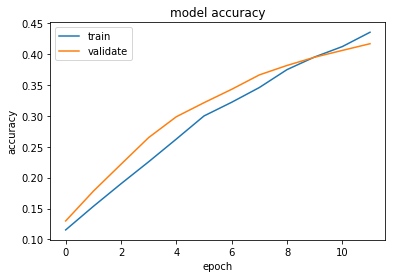

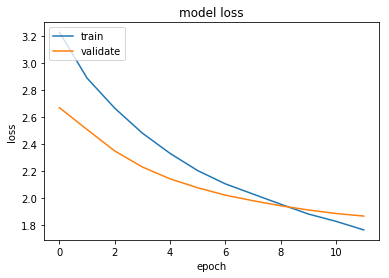

Train on 15684 samples, validate on 6740 samples
Epoch 1/1
15684/15684 [==============================] - 3s - loss: 1.7454 - acc: 0.4390 - val_loss: 1.8470 - val_acc: 0.4240
ll_model.optimizer.lr: 1e-07
train_last_layer, model just created from Vgg16(), # layers =  38
@ end of train_last_layer, # layers =  38
Number of layers :  38
0 <class 'keras.layers.core.Lambda'> , trainable: False
input: (None, 3, 224, 224) , output: (None, 3, 224, 224) , len(weights) 0 

1 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: False
input: (None, 3, 224, 224) , output: (None, 3, 226, 226) , len(weights) 0 

2 <class 'keras.layers.convolutional.Convolution2D'> , trainable: False
input: (None, 3, 226, 226) , output: (None, 64, 224, 224) , len(weights) 2 

3 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: False
input: (None, 64, 224, 224) , output: (None, 64, 226, 226) , len(weights) 0 

4 <class 'keras.layers.convolutional.Convolution2D'> , trainable: False
input: (None, 

count: 3
l1: <keras.layers.core.Dropout object at 0x7fe175f54d90>
l2: <keras.layers.core.Dropout object at 0x7fe16d103e50>
l1.get_weights(): 0
l2.get_weights(): 0
count: 4
l1: <keras.layers.normalization.BatchNormalization object at 0x7fe175f54cd0>
l2: <keras.layers.normalization.BatchNormalization object at 0x7fe16d0ae1d0>
l1.get_weights(): 4
l2.get_weights(): 4
count: 5
l1: <keras.layers.core.Dropout object at 0x7fe175f54a10>
l2: <keras.layers.core.Dropout object at 0x7fe16d084890>
l1.get_weights(): 0
l2.get_weights(): 0
count: 6
l1: <keras.layers.core.Dense object at 0x7fe175f54a50>
l2: <keras.layers.core.Dense object at 0x7fe16d0291d0>
l1.get_weights(): 2
l2.get_weights(): 2
marker AA
Train on 15684 samples, validate on 6740 samples
Epoch 1/8
15684/15684 [==============================] - 46s - loss: 0.8172 - acc: 0.7499 - val_loss: 0.0845 - val_acc: 0.9843
Epoch 2/8
15684/15684 [==============================] - 49s - loss: 0.1396 - acc: 0.9667 - val_loss: 0.0354 - val_acc: 0.9935

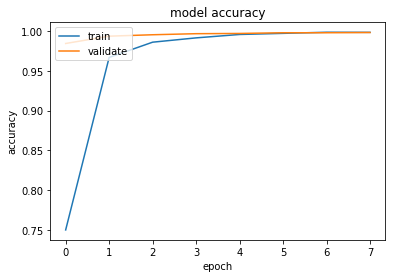

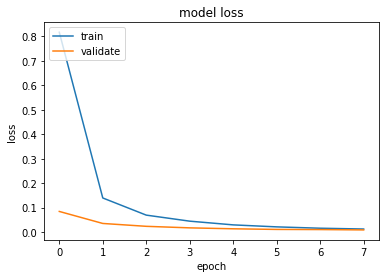

marker BB
marker CC
marker DD
type(val_batches): <class 'keras.preprocessing.image.NumpyArrayIterator'> val_batches.n: 6740
len(conv_model.layers): 31
showLayersInfo(conv_model): after adding get_fc_layers to conv_model
Number of layers :  38
0 <class 'keras.layers.core.Lambda'> , trainable: False
input: (None, 3, 224, 224) , output: (None, 3, 224, 224) , len(weights) 0 

1 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: False
input: (None, 3, 224, 224) , output: (None, 3, 226, 226) , len(weights) 0 

2 <class 'keras.layers.convolutional.Convolution2D'> , trainable: False
input: (None, 3, 226, 226) , output: (None, 64, 224, 224) , len(weights) 2 

3 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: False
input: (None, 64, 224, 224) , output: (None, 64, 226, 226) , len(weights) 0 

4 <class 'keras.layers.convolutional.Convolution2D'> , trainable: False
input: (None, 64, 226, 226) , output: (None, 64, 224, 224) , len(weights) 2 

5 <class 'keras.layers.pooli

15684/15684 [==============================] - 615s - loss: 0.3543 - acc: 0.8915 - val_loss: 0.0115 - val_acc: 0.9963
Epoch 2/8
15684/15684 [==============================] - 615s - loss: 0.2419 - acc: 0.9304 - val_loss: 0.0122 - val_acc: 0.9969
Epoch 3/8
15684/15684 [==============================] - 615s - loss: 0.1784 - acc: 0.9493 - val_loss: 0.0111 - val_acc: 0.9967
Epoch 4/8
15684/15684 [==============================] - 615s - loss: 0.1569 - acc: 0.9556 - val_loss: 0.0109 - val_acc: 0.9972
Epoch 5/8
15684/15684 [==============================] - 614s - loss: 0.1253 - acc: 0.9648 - val_loss: 0.0099 - val_acc: 0.9978
Epoch 6/8
15684/15684 [==============================] - 615s - loss: 0.1185 - acc: 0.9665 - val_loss: 0.0098 - val_acc: 0.9978
Epoch 7/8
15684/15684 [==============================] - 615s - loss: 0.1012 - acc: 0.9728 - val_loss: 0.0100 - val_acc: 0.9976
Epoch 8/8
15684/15684 [==============================] - 615s - loss: 0.0897 - acc: 0.9762 - val_loss: 0.0099 - va

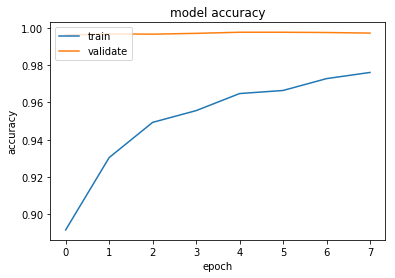

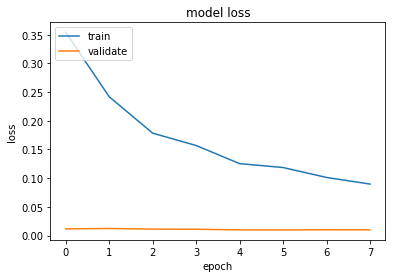

Epoch 1/10
15684/15684 [==============================] - 615s - loss: 0.0833 - acc: 0.9774 - val_loss: 0.0105 - val_acc: 0.9975
Epoch 2/10
15684/15684 [==============================] - 628s - loss: 0.0762 - acc: 0.9793 - val_loss: 0.0095 - val_acc: 0.9973
Epoch 3/10
15684/15684 [==============================] - 615s - loss: 0.0711 - acc: 0.9811 - val_loss: 0.0092 - val_acc: 0.9975
Epoch 4/10
15684/15684 [==============================] - 615s - loss: 0.0690 - acc: 0.9815 - val_loss: 0.0104 - val_acc: 0.9976
Epoch 5/10
15684/15684 [==============================] - 615s - loss: 0.0594 - acc: 0.9842 - val_loss: 0.0094 - val_acc: 0.9978
Epoch 6/10
15684/15684 [==============================] - 615s - loss: 0.0603 - acc: 0.9839 - val_loss: 0.0093 - val_acc: 0.9973
Epoch 7/10
15684/15684 [==============================] - 615s - loss: 0.0533 - acc: 0.9864 - val_loss: 0.0094 - val_acc: 0.9973
Epoch 8/10
15684/15684 [==============================] - 615s - loss: 0.0488 - acc: 0.9877 - val

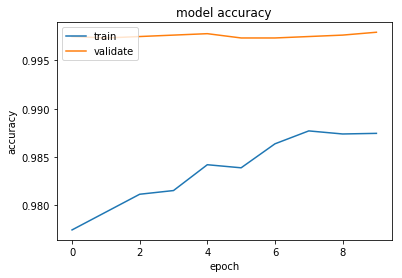

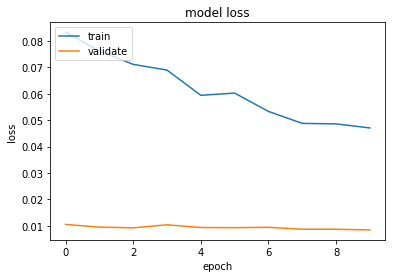

run garbage collection.
garbage collection completed.


In [48]:
#build the ensemble
num_emsembles = 1  #was 5, reduced to 1 to optimise training parameters.
#multiple model builds, model trainings. takes long time.
for i in range(num_emsembles):  
    i = str(i)
    print ("i:", i)
    model = train_last_layer(i)
    #a tthis point, model = vgg16 model, minus last three layers, plus layers BatchNormalization + Dropout + Dense
    #get_ll_layers:create 3 layers, BatchNormalization + Dropout + Dense
    #train_last_layer uses get_ll_layers to create 3 layer model, trains it, then pops last 3 layers from vgg16model
    #at end of train_last_layer model has 38 layers with last three layers being BatchNormalization + Dropout + Dense

    train_dense_layers(i, model)
    print ("run garbage collection.")
    gc.collect()
    print ("garbage collection completed.")
print ("completed.")

In [ ]:
#marker AA
#epoch 1/8 acc: 0.74 val_acc: 0.98 <1m per epoch with production data on p2.xlarge
#epoch 8/8 acc: 0.998 val_acc: 0.998 <1m per epoch with production data on p2.xlarge
#marker FF
#epoch 1/1           loss: 0.7727 - acc: 0.7531 - val_loss: 0.0101 - val_acc: 0.9975 10 minutes to run
#epoch 1/8 -  615s - loss: 0.3543 - acc: 0.8915 - val_loss: 0.0115 - val_acc: 0.9963
#Epoch 1/10 - 615s - loss: 0.0833 - acc: 0.9774 - val_loss: 0.0105 - val_acc: 0.9975
#

In [61]:
for i in range(num_emsembles):
    print (MODEL_PATH + s_or_p + 'aug' + str(i) + '.h5')

/home/ubuntu/fastai/data/state/models/_prod_aug0.h5


Train on 15684 samples, validate on 6740 samples
Epoch 1/12
15684/15684 [==============================] - 2s - loss: 3.2223 - acc: 0.1146 - val_loss: 2.6038 - val_acc: 0.1398
Epoch 2/12
15684/15684 [==============================] - 3s - loss: 2.8776 - acc: 0.1558 - val_loss: 2.4377 - val_acc: 0.1856
Epoch 3/12
15684/15684 [==============================] - 3s - loss: 2.6703 - acc: 0.1876 - val_loss: 2.2898 - val_acc: 0.2286
Epoch 4/12
15684/15684 [==============================] - 3s - loss: 2.4866 - acc: 0.2233 - val_loss: 2.1789 - val_acc: 0.2663
Epoch 5/12
15684/15684 [==============================] - 3s - loss: 2.3536 - acc: 0.2631 - val_loss: 2.0958 - val_acc: 0.2997
Epoch 6/12
15684/15684 [==============================] - 3s - loss: 2.2264 - acc: 0.2931 - val_loss: 2.0335 - val_acc: 0.3220
Epoch 7/12
15684/15684 [==============================] - 3s - loss: 2.1274 - acc: 0.3237 - val_loss: 1.9822 - val_acc: 0.3414
Epoch 8/12
15684/15684 [==============================] - 3s -

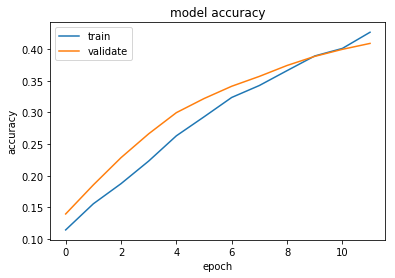

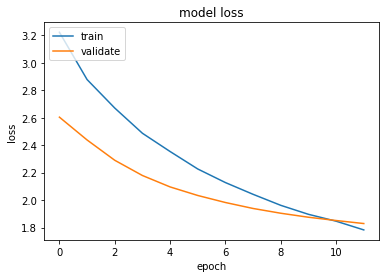

Train on 15684 samples, validate on 6740 samples
Epoch 1/1
15684/15684 [==============================] - 3s - loss: 1.7380 - acc: 0.4367 - val_loss: 1.8116 - val_acc: 0.4169
ll_model.optimizer.lr: 1e-07
train_last_layer, model just created from Vgg16(), # layers =  38
@ end of train_last_layer, # layers =  38
Number of layers :  38
0 <class 'keras.layers.core.Lambda'> , trainable: False
input: (None, 3, 224, 224) , output: (None, 3, 224, 224) , len(weights) 0 

1 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: False
input: (None, 3, 224, 224) , output: (None, 3, 226, 226) , len(weights) 0 

2 <class 'keras.layers.convolutional.Convolution2D'> , trainable: False
input: (None, 3, 226, 226) , output: (None, 64, 224, 224) , len(weights) 2 

3 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: False
input: (None, 64, 224, 224) , output: (None, 64, 226, 226) , len(weights) 0 

4 <class 'keras.layers.convolutional.Convolution2D'> , trainable: False
input: (None, 

In [62]:
ens_model2 = train_last_layer(str(11))
#just using this method to load the same stack of layers. ignore the accuracy returned.

In [63]:
ens_model2.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_4 (Lambda)                (None, 3, 224, 224)   0           lambda_input_4[0][0]             
____________________________________________________________________________________________________
zeropadding2d_40 (ZeroPadding2D) (None, 3, 226, 226)   0           lambda_4[0][0]                   
____________________________________________________________________________________________________
convolution2d_40 (Convolution2D) (None, 64, 224, 224)  1792        zeropadding2d_40[0][0]           
____________________________________________________________________________________________________
zeropadding2d_41 (ZeroPadding2D) (None, 64, 226, 226)  0           convolution2d_40[0][0]           
___________________________________________________________________________________________

In [64]:
for layer in ens_model2.layers: layer.trainable=True

In [65]:
def get_ens_pred(arr, fname):
    ens_pred = []
    for i in range(num_emsembles):
        i = str(i)
        print ("loading weights file:", i)
        ens_model2.load_weights('{}{}{}.h5'.format(MODEL_PATH, fname, i))
        print ("predicting from weights file:", i)
        preds = ens_model2.predict(arr, batch_size=batch_size)
        ens_pred.append(preds)
        print ("len(ens_pred):", len(ens_pred), ", len(preds):", len(preds))
    return ens_pred

In [66]:
#recall: val = get_data(WORKING_VALID)
#val: (1500, 3, 224, 224)

val_pred2 = get_ens_pred(val, s_or_p + 'aug')
#nb: this loads weights from the files with 'aug' in filename. this is the final model build in method train_dense_layers

loading weights file: 0
predicting from weights file: 0
len(ens_pred): 1 , len(preds): 6740


In [67]:
print ("len(val_pred2):", len(val_pred2))
print(val_pred2[0].shape)
print(val_pred2[0][0:10, :])

len(val_pred2): 1
(6740, 10)
[[  9.9995e-01   7.0427e-08   1.2985e-07   4.6891e-05   2.5912e-07   1.9961e-07   4.7701e-07
    9.4941e-08   5.6607e-07   1.9675e-06]
 [  9.9995e-01   8.4122e-07   2.9594e-07   3.6547e-05   7.5534e-06   1.0454e-06   2.7157e-07
    2.5258e-08   2.3818e-07   7.1831e-06]
 [  9.9501e-01   1.3910e-04   5.0448e-05   2.8919e-03   7.6346e-04   7.2050e-04   1.5548e-05
    1.6751e-04   1.4851e-04   9.2109e-05]
 [  1.0000e+00   3.1543e-07   4.1171e-08   6.2563e-07   3.5438e-09   4.2188e-08   7.7889e-10
    5.4031e-09   2.5818e-09   8.1633e-08]
 [  9.9959e-01   5.2562e-07   4.9957e-07   6.8246e-06   2.5098e-05   2.7391e-05   1.4877e-07
    3.7252e-07   7.4150e-08   3.5114e-04]
 [  9.9995e-01   2.0008e-06   4.4216e-06   7.8098e-06   6.1673e-06   9.4231e-07   1.9403e-06
    1.4685e-06   3.2993e-06   2.4344e-05]
 [  1.0000e+00   6.5096e-07   6.3606e-08   2.9063e-07   3.4557e-08   1.9838e-08   1.6793e-08
    1.9050e-08   3.5463e-09   2.0004e-07]
 [  1.0000e+00   1.1307e-0

In [68]:
preds = val_pred2
preds = np.around(preds, decimals=1)
print (type(preds))
print (np.unique(preds))
preds[0][0:5,]


<type 'numpy.ndarray'>
[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1. ]


array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]], dtype=float32)

In [69]:
#calc categorical_accuracy for each prediction and for the average.
cat_acc = []
for i in range(num_emsembles):
    temp_val_preds = val_pred2[i]
    print ("i:", i, type(temp_val_preds), temp_val_preds.shape)
    cat_acc.append(float(categorical_accuracy(val_labels, temp_val_preds).eval()))
    print ("i:", i, type(temp_val_preds), temp_val_preds.shape, ", categorical accuracy:", cat_acc[i])
print ("cat_acc:", type(cat_acc), cat_acc)


i: 0 <type 'numpy.ndarray'> (6740, 10)
i: 0 <type 'numpy.ndarray'> (6740, 10) , categorical accuracy: 0.997922837734
cat_acc: <type 'list'> [0.9979228377342224]


In [70]:
val_avg_preds2 = np.stack(val_pred2).mean(axis=0)
#get the mean prediction across all 
print ("type(val_avg_preds2):", type(val_avg_preds2), val_avg_preds2.shape)
print(val_avg_preds2[0:10, :])

type(val_avg_preds2): <type 'numpy.ndarray'> (6740, 10)
[[  9.9995e-01   7.0427e-08   1.2985e-07   4.6891e-05   2.5912e-07   1.9961e-07   4.7701e-07
    9.4941e-08   5.6607e-07   1.9675e-06]
 [  9.9995e-01   8.4122e-07   2.9594e-07   3.6547e-05   7.5534e-06   1.0454e-06   2.7157e-07
    2.5258e-08   2.3818e-07   7.1831e-06]
 [  9.9501e-01   1.3910e-04   5.0448e-05   2.8919e-03   7.6346e-04   7.2050e-04   1.5548e-05
    1.6751e-04   1.4851e-04   9.2109e-05]
 [  1.0000e+00   3.1543e-07   4.1171e-08   6.2563e-07   3.5438e-09   4.2188e-08   7.7889e-10
    5.4031e-09   2.5818e-09   8.1633e-08]
 [  9.9959e-01   5.2562e-07   4.9957e-07   6.8246e-06   2.5098e-05   2.7391e-05   1.4877e-07
    3.7252e-07   7.4150e-08   3.5114e-04]
 [  9.9995e-01   2.0008e-06   4.4216e-06   7.8098e-06   6.1673e-06   9.4231e-07   1.9403e-06
    1.4685e-06   3.2993e-06   2.4344e-05]
 [  1.0000e+00   6.5096e-07   6.3606e-08   2.9063e-07   3.4557e-08   1.9838e-08   1.6793e-08
    1.9050e-08   3.5463e-09   2.0004e-07]

In [ ]:
print ("categorical accuracy from mean      :", float(categorical_accuracy(val_labels, val_avg_preds2).eval()))
print ("best individual categorical accuracy:", np.max(cat_acc))
#NB: mean accuracy is higher because it is choosing the best prediction row by row. then comparing with actual category.

categorical accuracy from mean      : 0.997922837734
best individual categorical accuracy: 0.997922837734


In [ ]:
startTime= datetime.now()
print ("startTime:", startTime)
test = get_data(WORKING_TEST)
print ("test:", test.shape)

timeElapsed=datetime.now()-startTime
print ('Time elapsed (hh:mm:ss.ms) {}'.format(timeElapsed))


startTime: 2018-01-05 09:05:07.222027
Found 79726 images belonging to 1 classes.


In [ ]:
print ("test:", type(test), test.shape)

In [ ]:
#recall: test = get_data(WORKING_TEST)
#<type 'numpy.ndarray'> (2500, 3, 224, 224)
startTime= datetime.now()
print ("startTime:", startTime)

test_pred2 = get_ens_pred(test, s_or_p + 'aug')

timeElapsed=datetime.now()-startTime
print('Time elapsed (hh:mm:ss.ms) {}'.format(timeElapsed))


#print ("test_pred2.shape:", test_pred2.shape)
#approx time to run : production version: 

In [ ]:
print ("len(val_pred2):", len(test_pred2))
print(test_pred2[0].shape)


In [ ]:
print(test_pred2[0][0:10, :])

In [ ]:
avg_test_pred2 = np.stack(test_pred2).mean(axis=0)
#get the mean prediction across all 
print ("type(avg_test_pred2):", type(avg_test_pred2), avg_test_pred2.shape)
print(avg_test_pred2[0:10, :])

In [ ]:
#NB: need to check last few block suit 10 category predictions and output format required for kaggle submisison.

In [ ]:
preds_submit = np.around(avg_test_pred2, decimals=1)
preds_submit[0:5,]

In [ ]:
test_filename[0:5], len(test_filename)

In [ ]:
#create list of filenames with the unknown/ dropped
filenames = []
for i in range(len(test_filename)):
    filenames.append(test_filename[i][8:])
    #print (filenames[i])
print (filenames[0:5])

In [ ]:
filenames_array = np.reshape(np.array(filenames), (len(filenames),1))
filenames_array.shape

In [ ]:
preds_submit.shape

In [ ]:
results2 = pd.concat([pd.DataFrame(filenames),pd.DataFrame(preds_submit)],axis=1)

In [ ]:
results2.shape

In [ ]:
CATEGORIES
categories_ = []
for categ in CATEGORIES:
    #print (categ[0:2])
    categories_.append(categ[0:2])
categories_

In [ ]:
results2.columns = ['img']+categories_

In [ ]:
list(results2)

In [ ]:
results2.head()

In [ ]:
RESULTS_PATH

In [ ]:
%cd $RESULTS_PATH
submission_file_name = "ensemble_submit"+ s_or_p +".csv"
results2.to_csv(submission_file_name, index=False, float_format='%.1f')
print ("written to :", submission_file_name)

In [ ]:
import matplotlib.image as mpimg
img=mpimg.imread(WORKING_TEST+UNKNOWN + filenames[0])
imgplot = plt.imshow(img)
results2.head(1)
cat_desc[3]

kg submit  ensemble_submit_sample_.csv -u user-email -p password -c state-farm-distracted-driver-detection

In [ ]:
#Submission : must have 79726 rows